### ESA CCI data example for an entire year's timeseries

Start by performing the required imports

In [1]:
import wget
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime, timedelta

In [2]:
# You can find more information about the data in the User guide for ESA CCI+ Vegetation data, CRDP-1:
# https://data.ceda.ac.uk/neodc/esacci/vegetation_parameters/docs/L3S/vp_products/v1.0
# https://climate.esa.int/media/documents/VP-CCI_D4.2_PUG_V1.2.pdf

Define the tile and the year.

In [2]:
tile = 'X18Y02'

# Data availability: every 5 days, counting from January 1
# min-year: 2000, max-year: 2020
year = 2019

 Download the data as a timeseries for the entire year.
 
 Note that downloads are skipped if files are already downloaded on the local disk (e.g when it is needed to resume a partial download).

In [3]:
d = datetime(year, 1, 1)
delta = timedelta(days = 5)
end = datetime(year, 12, 31)

datasets = []
dates = []

base_url = 'https://dap.ceda.ac.uk/neodc/esacci/vegetation_parameters/data/L3S/vp_products/v1.0/transect'

while d < end:
    year = d.strftime('%Y')
    month = d.strftime('%m')
    day = d.strftime('%d')
    filename = 'ESACCI-VEGETATION-L3S-VP_PRODUCTS-MERGED-tile_' + tile + '-' + year + month + day + '-fv1.0.nc'
    url = base_url + '/' + year + '/' + tile + '/' + filename
    print(url)
    if not os.path.exists(filename):
        wget.download(url)
    datasets.append(Dataset(filename))
    dates.append(d)
    d = d + delta

print(len(datasets), 'files in year', year)

https://dap.ceda.ac.uk/neodc/esacci/vegetation_parameters/data/L3S/vp_products/v1.0/transect/2019/X18Y02/ESACCI-VEGETATION-L3S-VP_PRODUCTS-MERGED-tile_X18Y02-20190101-fv1.0.nc
https://dap.ceda.ac.uk/neodc/esacci/vegetation_parameters/data/L3S/vp_products/v1.0/transect/2019/X18Y02/ESACCI-VEGETATION-L3S-VP_PRODUCTS-MERGED-tile_X18Y02-20190106-fv1.0.nc
https://dap.ceda.ac.uk/neodc/esacci/vegetation_parameters/data/L3S/vp_products/v1.0/transect/2019/X18Y02/ESACCI-VEGETATION-L3S-VP_PRODUCTS-MERGED-tile_X18Y02-20190111-fv1.0.nc
https://dap.ceda.ac.uk/neodc/esacci/vegetation_parameters/data/L3S/vp_products/v1.0/transect/2019/X18Y02/ESACCI-VEGETATION-L3S-VP_PRODUCTS-MERGED-tile_X18Y02-20190116-fv1.0.nc
https://dap.ceda.ac.uk/neodc/esacci/vegetation_parameters/data/L3S/vp_products/v1.0/transect/2019/X18Y02/ESACCI-VEGETATION-L3S-VP_PRODUCTS-MERGED-tile_X18Y02-20190121-fv1.0.nc
https://dap.ceda.ac.uk/neodc/esacci/vegetation_parameters/data/L3S/vp_products/v1.0/transect/2019/X18Y02/ESACCI-VEGETATI

Plot the Leaf Area Index of the first image of the year (January 1), to get an appreciation in a figure.

In [7]:
lat = datasets[0].variables['lat'][:]
lon = datasets[0].variables['lon'][:]

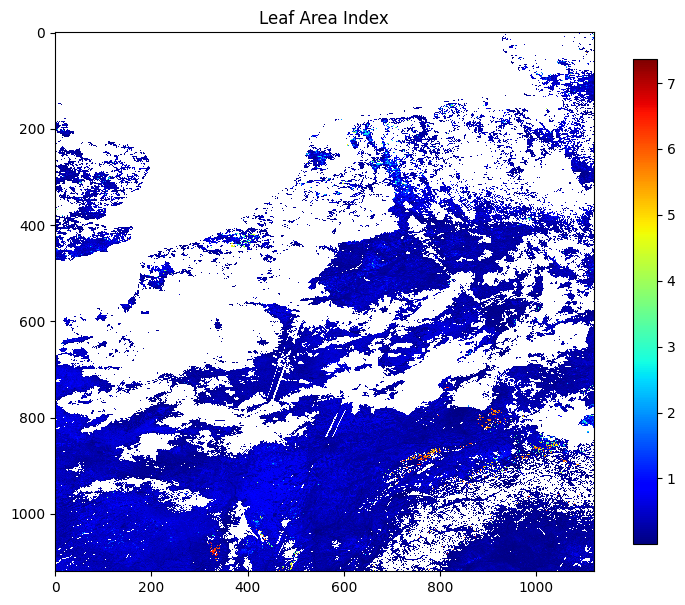

In [8]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(datasets[0].variables['LAI'][:][0], interpolation='none', cmap='jet')
plt.colorbar(shrink=0.9)
t = plt.title('Leaf Area Index')

Define a location of interest, by providing a latitude and a longitude. The location must be within the tile that was selected.

In [9]:
location={'lat': 51, 'lon': 5}
y_pos = np.argmin( np.abs( lat - location['lat'] ) )
x_pos = np.argmin( np.abs( lon - location['lon'] ) )
print('Location as a pixel-position:', y_pos, x_pos)

Location as a pixel-position: 448 560


Extract timeseries data for the given location

In [22]:
RETR_UNTRUSTED = 256 # bit 8 of the 10-bits mask 'invcode'
RETR_LOW_QUALITY = 512 # bit 9 of the 10-bits mask 'invcode'

lai_values = []
lai_unc_values = []
lai_values_trusted = []
lai_values_high_quality = []

for dataset in datasets:
    LAI = dataset.variables['LAI'][:][0]
    LAI_unc = dataset.variables['LAI_ERR'][:][0]
    invcode = dataset.variables['invcode'][:][0]
    LAI_TRUSTED = np.ma.masked_where(invcode & RETR_UNTRUSTED == RETR_UNTRUSTED, LAI)
    LAI_HIGH_QUALITY = np.ma.masked_where(invcode & RETR_LOW_QUALITY == RETR_LOW_QUALITY, LAI)
    lai = LAI[y_pos, x_pos]
    lai_unc = LAI_unc[y_pos, x_pos]
    lai_trusted = np.nan if invcode[y_pos, x_pos] & RETR_UNTRUSTED == RETR_UNTRUSTED else lai
    lai_high_quality = np.nan if invcode[y_pos, x_pos] & RETR_LOW_QUALITY == RETR_LOW_QUALITY else lai
    lai = np.ma.filled(lai, np.nan)
    lai_trusted = np.ma.filled(lai_trusted, np.nan)
    lai_high_quality = np.ma.filled(lai_high_quality, np.nan)
    lai_unc_values.append(lai_unc)
    lai_values.append(lai)
    lai_values_trusted.append(lai_trusted)
    lai_values_high_quality.append(lai_high_quality)

Plot the three timeseries arrays. It can be observed that the 3 graphs overlap, but the `LAI high quality` has the least data availability.

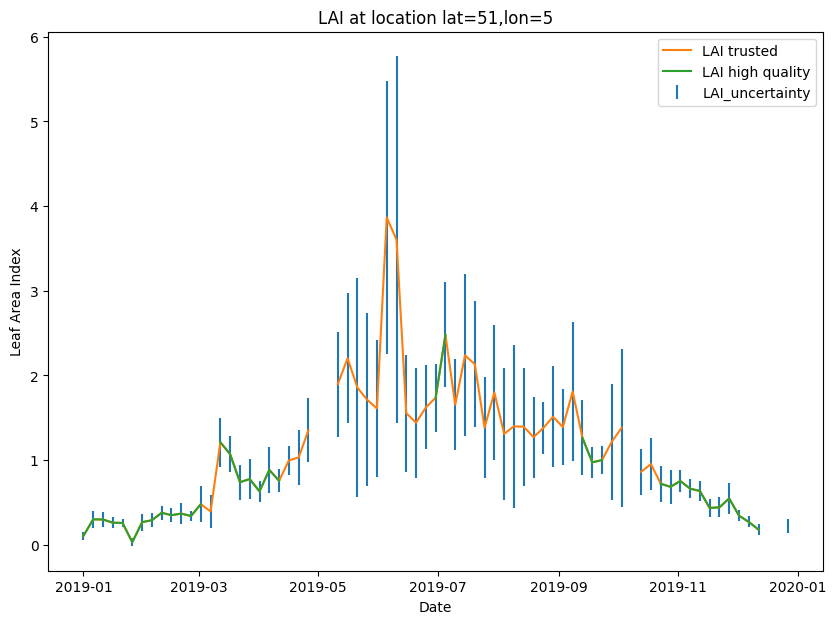

In [33]:
fig = plt.figure(figsize =(10, 7))
#plt.plot(dates, lai_unc_values, label='LAI')
plt.errorbar(dates, lai_values,lai_unc_values, label='LAI_uncertainty', linestyle = 'none')
plt.plot(dates, lai_values_trusted, label = 'LAI trusted')
plt.plot(dates, lai_values_high_quality, label = 'LAI high quality')

plt.xlabel('Date')
plt.ylabel('Leaf Area Index')
plt.title('LAI at location lat='+str(location['lat'])+',lon='+str(location['lon']))
leg = plt.legend()